### Read the data from the input Excel file

In [1]:
import pandas as pd
inputFileName = "DataBlender.xlsx"
paramDF = pd.read_excel(inputFileName, "Param", skiprows=2)
rawMaterialsDF = pd.read_excel(inputFileName, "RawMaterials", skiprows=2)
finishedGoodsDF = pd.read_excel(inputFileName, "FinishedGoods", skiprows=2)

### Set the data into list and dict, easier to manipulate

In [2]:
#Raw materials characteristics
rawMaterials_items = list(rawMaterialsDF['Raw materials'])
costRM = list(rawMaterialsDF['Cost'])
capacityRM = list(rawMaterialsDF['Capacity'])
volumeMinRM = list(rawMaterialsDF['VolumeMin'])
supplierRM = list(rawMaterialsDF['Supplier'])
suppliers_items = list(set(supplierRM))  #supplier list, obtained by removing duplicates

componentsRM = dict()
componentsRM['Component1'] = list(rawMaterialsDF['Component1'])
componentsRM['Component2'] = list(rawMaterialsDF['Component2'])
componentsRM['Component3'] = list(rawMaterialsDF['Component3'])

#Finished goods characteristics
finishedGoods_items = list(finishedGoodsDF['Finished goods'])
demandFG = list(finishedGoodsDF['Demand'])

componentsMinFG = dict()
componentsMinFG['Component1'] = list(finishedGoodsDF['MinComponent1'])
componentsMinFG['Component2'] = list(finishedGoodsDF['MinComponent2'])
componentsMinFG['Component3'] = list(finishedGoodsDF['MinComponent3'])

componentsMaxFG = dict()
componentsMaxFG['Component1'] = list(finishedGoodsDF['MaxComponent1'])
componentsMaxFG['Component2'] = list(finishedGoodsDF['MaxComponent2'])
componentsMaxFG['Component3'] = list(finishedGoodsDF['MaxComponent3'])


### Create your linear program

In [3]:
from pulp import *
prob = LpProblem("BlenderProblem",LpMinimize)

### Add variables

In [4]:
RecipeVar = LpVariable.dicts("Recipe", ((i, j) for i in rawMaterials_items for j in finishedGoods_items), 
                             lowBound=0, cat='Continuous')
RM_VolumeVar = LpVariable.dicts("RMvolume", (i for i in rawMaterials_items), lowBound=0, cat='Continuous')
FG_VolumeVar = LpVariable.dicts("FGvolume", (j for j in finishedGoods_items), lowBound=0, cat='Continuous')

### Add objectives

In [5]:
prob += lpSum([costRM[iRM] * RM_VolumeVar[vRM] for iRM, vRM in enumerate(rawMaterials_items)])

### Add constraints

In [6]:
#Define RM_VolumeVar
for iRM in rawMaterials_items : 
    prob += lpSum([RecipeVar[iRM,iFG] for iFG in finishedGoods_items]) == RM_VolumeVar[iRM], "defVolumeRM[%s]"%(iRM)
    
#Define FG_VolumeVar
for iFG in finishedGoods_items : 
    prob += lpSum([RecipeVar[iRM,iFG] for iRM in rawMaterials_items]) == FG_VolumeVar[iFG], "defVolumeFG[%s]"%(iFG)
    
#Capacity constraint
for iRM, vRM in enumerate(rawMaterials_items) : 
    prob += RM_VolumeVar[vRM] <= capacityRM[iRM], "capacity[%s]"%(iRM)

#Demand constraint
for iFG, vFG in enumerate(finishedGoods_items) : 
    prob += FG_VolumeVar[vFG] >= demandFG[iFG], "demandFG[%s]"%(iFG)
    
#Min & max components in the finished goods
for iComponent in ['Component1', 'Component2', 'Component3']:
    for iFG, vFG in enumerate(finishedGoods_items) : 
        #print(componentsMinFG[iComponent][iFG])
        prob += lpSum([componentsRM[iComponent][iRM] * RecipeVar[vRM,vFG] for iRM, vRM in enumerate(rawMaterials_items)]) >= FG_VolumeVar[vFG] * componentsMinFG[iComponent][iFG]
        prob += lpSum([componentsRM[iComponent][iRM] * RecipeVar[vRM,vFG] for iRM, vRM in enumerate(rawMaterials_items)]) <= FG_VolumeVar[vFG] * componentsMaxFG[iComponent][iFG]


In [6]:
rawMaterials_items

['I1', 'I2', 'I3', 'I4', 'I5', 'I6', 'I7', 'I8', 'I9', 'I10']

### Add min volume variables & constraints

In [7]:
if paramDF['Value'][0] == 1 or paramDF['Value'][1] == 1:  #Param "ConsiderVolumeMin" or "ConsiderDiscount"
    
    #Binary variables : isUsed_RM_Var
    isUsedRMVar = LpVariable.dicts("isUsed", (i for i in rawMaterials_items), cat='Binary')
    
    #Def isUsedRM : RM_VolumeVar[vRM] <= Capacity[iRM] * isUsed[vRM]
    for iRM, vRM in enumerate(rawMaterials_items) : 
        prob += RM_VolumeVar[vRM]  <= capacityRM[iRM] * isUsedRMVar[vRM], "def_isUsedRM[%s]"%(iRM)

    #Min volume constraint : VolumeMin[iRM] * isUsed[vRM] <= RM_VolumeVar[vRM]
    for iRM, vRM in enumerate(rawMaterials_items) : 
        prob += volumeMinRM[iRM] * isUsedRMVar[vRM] <= RM_VolumeVar[vRM], "volumeMin_RM[%s]"%(iRM)

### Add discounts variables & objective

In [8]:
if paramDF['Value'][1] == 1:  #Param "ConsiderDiscount"
    
    #Binary variables per supplier : areBothUsedRMVar
    areBothUsedRMVar = LpVariable.dicts("areBothUsed", (i for i in suppliers_items), cat='Binary')
    
    for iSupplier in suppliers_items:
        
        #Cst stating that areBothUsed[vRM1][vRM2] <= isUsedRMVar[vRM1] and areBothUsed[vRM1][vRM2] <= isUsedRMVar[vRM2]
        for iRM,vRM in enumerate(rawMaterials_items) :
            if supplierRM[iRM] == iSupplier :
                prob += areBothUsedRMVar[iSupplier] <= isUsedRMVar[vRM], "def_areBothUsedRM[%s][%s]"%(iSupplier,vRM)
                
            #This constraint is valid but useless since the model tries to minimize the cost, i.e. to set areBothUsedVar=1
            #for iRM1,vRM1 in enumerate(rawMaterials_items) :
            #    if iRM1 > iRM and supplierRM[iRM1] == iSupplier: 
            #        prob += areBothUsedRMVar[iSupplier] >= isUsedRMVar[vRM] + isUsedRMVar[vRM1] -1, "def2_areBothUsedRM[%s][%s]"%(iSupplier,iRM)

        #Add the discount in the objective function
        discount = paramDF['Value'][2]  #discount in $
        prob += lpSum([costRM[iRM] * RM_VolumeVar[vRM] for iRM, vRM in enumerate(rawMaterials_items)]) \
                    - lpSum([discount * areBothUsedRMVar[iSupplier]  for iSupplier in suppliers_items])
                

### Solve the problem and store the variable into a dictionnary

In [9]:
#prob.writeLP("blenderProblem.lp", writeSOS=1, mip=1)
prob.solve()
print("Status:", LpStatus[prob.status])
print ("Objective = ", value(prob.objective))
varsDict = {}
for v in prob.variables():
    varsDict[v.name] = v.varValue
    if "RMvolume" in v.name:
        print(v.name, "=", v.varValue)
        
for name, c in list(prob.constraints.items()):
    if "capacity" in name or "demand" in name:
        print(name, ":", c.pi, "\t\t", c.slack)


Status: Optimal
Objective =  138175.55667710002
RMvolume_I1 = 760.89478
RMvolume_I10 = 219.20615
RMvolume_I2 = 119.89907
RMvolume_I3 = 600.0
RMvolume_I4 = 500.0
RMvolume_I5 = 500.0
RMvolume_I6 = 800.0
RMvolume_I7 = 1000.0
RMvolume_I8 = 1000.0
RMvolume_I9 = 0.0
capacity_0_ : 0.0 		 239.10522000000003
capacity_1_ : 0.0 		 880.1009300000001
capacity_2_ : -4.8070588 		 -0.0
capacity_3_ : -4.0152941 		 -0.0
capacity_4_ : -0.068823529 		 -0.0
capacity_5_ : -3.9088235 		 -0.0
capacity_6_ : -1.8492785 		 -0.0
capacity_7_ : -0.73823529 		 -0.0
capacity_8_ : 0.0 		 1000.0
capacity_9_ : 0.0 		 780.79385
demandFG_0_ : 27.114706 		 -0.0
demandFG_1_ : 25.822941 		 -0.0
demandFG_2_ : 25.177059 		 -0.0
demandFG_3_ : 28.557118 		 -0.0


import matplotlib.pyplot as plt
import numpy as np

myArray = np.zeros((len(rawMaterials_items), len(finishedGoods_items)), dtype=np.float)
for i in rawMaterials_items:
    for j in finishedGoods_items :
        myArray[i][j] = prob.variables("Recipe_('I1',_'O1')").varValue
plt.imshow(myArray, cmap='hot', interpolation='nearest')
plt.show()

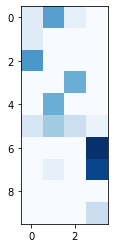

[[ 117.95983    560.24096     82.693986     0.       ]
 [ 117.93649      0.           1.9625844    0.       ]
 [ 600.           0.           0.           0.       ]
 [   0.           0.         500.           0.       ]
 [   0.         500.           0.           0.       ]
 [ 158.98039    361.01549    215.34343     64.660691 ]
 [   0.           0.           0.        1000.       ]
 [   5.1232918   78.743546     0.         916.13316  ]
 [   0.           0.           0.           0.       ]
 [   0.           0.           0.         219.20615  ]]


In [10]:
import matplotlib.pyplot as plt 
import numpy as np

myArray = np.zeros((len(rawMaterials_items), len(finishedGoods_items)), dtype=np.float)


for iRM, vRM in enumerate(rawMaterials_items):
    for iFG, vFG in enumerate(finishedGoods_items): 
        myArray[iRM][iFG] = varsDict["Recipe_(\'%s\',_\'%s\')" %(vRM, vFG)]
plt.imshow(myArray, cmap='Blues', interpolation='nearest')
plt.show()
print(myArray)